# Harmonization Tutorial

In [ ]:
# If running in Colab, navigate to Runtime -> Change runtime type
# and ensure you're using a Python 3 runtime with GPU hardware accelerator
# installation in Colab can take several minutes

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yoseflab/scvi/blob/master/tests/notebooks/harmonization.ipynb)

In [ ]:
import sys
IN_COLAB = "google.colab" in sys.modules

def allow_notebook_for_test():
    print("Testing the harmonization notebook")

show_plot = True
test_mode = False
save_path = "data/"

if IN_COLAB:
    !pip install --quiet git+https://github.com/yoseflab/scvi@master#egg=scvi[notebooks]

In [ ]:
import matplotlib
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import numpy as np
import numpy.random as random
import pandas as pd
import scanpy as sc
import louvain

from scvi.dataset.dataset import GeneExpressionDataset
from scvi.inference import UnsupervisedTrainer
from scvi.models import SCANVI, VAE

from umap import UMAP

# Control UMAP numba warnings
import warnings; warnings.simplefilter('ignore')

if IN_COLAB:
    %matplotlib inline

# Use GPU
use_cuda = True

The raw data is provided in the Seurat notebook and can be downloaded [here](https://www.dropbox.com/s/79q6dttg8yl20zg/immune_alignment_expression_matrices.zip?dl=1)

# Tutorial

<font size='3'>This tutorial walks through the harmonization process, specifically making use of scVI and SCANVI, which are two tools that are applicable and useful for principled large-scale analysis of single-cell transcriptomics atlases. Data harmonization refers to the integration of two or more transcriptomics dataset into a single dataset on which any downstream analysis can be applied. The input datasets may come from very different sources and from samples with a different composition of cell types. 
<br><br>
__scVI__ is a deep generative model that has been developed for probabilistic representation of scRNA-seq data and performs well in both harmonization and harmonization-based annotation, going beyond just correcting batch effects. 
__SCANVI__ is a new method that is designed to harmonize datasets, while also explicitly leveraging any available labels to achieve more accurate annotation. SCANVI uses a semi-supervised generative model. 
<br><br>
The inference of both models (scVI, SCANVI) is done using neural networks, stochastic optimization, and variational inference and scales to millions of cells and multiple datasets. Furthermore, both methods provide a complete probabilistic representation of the data, which non-linearly controls not only for sample-to-sample bias, but also for other technical factors of variation such as over-dispersion, variable library size, and zero-inflation.
</font>


<font size='3'>The following tutorial is designed to provide an overview of the data harmonization methods, scVI and SCANVI. This tutorial runs through two examples: 1) Tabula Muris dataset and 2) Human dataset (Seurat)
<br>
Goals:
- Setting up and downloading datasets
- Performing data harmonization with scVI
- Performing marker selection from differentailly expressed genes for each cluster
- Performing differential expression within each cluster
</font>

### Dataset

#### The cell below is used to load in two human PBMC dataset, one stimulated and one control.

In [4]:
download_data = False
if IN_COLAB or download_data:
    !mkdir data
    !wget https://www.dropbox.com/s/79q6dttg8yl20zg/immune_alignment_expression_matrices.zip?dl=1 -O data/immune_alignment_expression_matrices.zip
    !cd data; unzip immune_alignment_expression_matrices.zip

mkdir: cannot create directory ‘data’: File exists
--2019-12-28 18:58:55--  https://www.dropbox.com/s/79q6dttg8yl20zg/immune_alignment_expression_matrices.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/79q6dttg8yl20zg/immune_alignment_expression_matrices.zip [following]
--2019-12-28 18:58:55--  https://www.dropbox.com/s/dl/79q6dttg8yl20zg/immune_alignment_expression_matrices.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1403acf060990a493fabdccbe5.dl.dropboxusercontent.com/cd/0/get/AvHUyrRQSPsh74XfdrAlCWOZSP4kPB0wvXSnuxJLlgj6apM0OtsnlR2yc1yjRznYyz0cztcOSreiw7S-rIjTfYitOGst7j6Tg5wsQztOufg3QA/file?dl=1# [following]
--2019-12-28 18:58:56--  https://uc1403acf060990a493fabdccbe5.dl.dropboxusercontent.com/cd/0/ge

In [5]:
# This can take several minutes
from scvi.dataset.csv import CsvDataset
filename = 'immune_stimulated_expression_matrix.txt.gz' if IN_COLAB else 'immune_stimulated_expression_matrix.txt'
stimulated = CsvDataset(filename=filename,
                        save_path=save_path,sep='\t', new_n_genes=35635, 
                        compression="gzip" if IN_COLAB else None)
filename = 'immune_control_expression_matrix.txt.gz' if IN_COLAB else 'immune_control_expression_matrix.txt'
control = CsvDataset(filename=filename,
                     save_path=save_path, sep='\t', new_n_genes=35635,
                     compression="gzip" if IN_COLAB else None)

[2019-12-28 19:01:13,912] INFO - scvi.dataset.csv | Preprocessing dataset
[2019-12-28 19:02:53,857] INFO - scvi.dataset.csv | Finished preprocessing dataset
[2019-12-28 19:02:56,328] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-12-28 19:02:56,330] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-12-28 19:02:56,912] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-12-28 19:02:57,473] INFO - scvi.dataset.dataset | Downsampled from 12875 to 12875 cells
[2019-12-28 19:02:57,476] INFO - scvi.dataset.dataset | Not subsampling. Expecting: 1 < (new_n_genes=35635) <= self.nb_genes
[2019-12-28 19:02:57,477] INFO - scvi.dataset.csv | Preprocessing dataset
[2019-12-28 19:04:39,096] INFO - scvi.dataset.csv | Finished preprocessing dataset
[2019-12-28 19:04:43,433] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-12-28 19:04:43,435] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-12-28 19:04:44,081]

In [6]:
# We subsample genes here so that computation works in Colab
if IN_COLAB:
    stimulated.subsample_genes(5000)
    control.subsample_genes(5000)

[2019-12-28 19:04:44,680] INFO - scvi.dataset.dataset | extracting highly variable genes


Transforming to str index.
/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_simple.py:284: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if isinstance(data, AnnData) and data.isview:


[2019-12-28 19:04:52,645] INFO - scvi.dataset.dataset | Downsampling from 35635 to 5000 genes
[2019-12-28 19:04:53,295] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-12-28 19:04:53,936] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2019-12-28 19:04:54,581] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-12-28 19:04:54,685] INFO - scvi.dataset.dataset | Downsampled from 12875 to 12875 cells
[2019-12-28 19:04:54,686] INFO - scvi.dataset.dataset | extracting highly variable genes


Transforming to str index.
/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_simple.py:284: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if isinstance(data, AnnData) and data.isview:


[2019-12-28 19:05:03,599] INFO - scvi.dataset.dataset | Downsampling from 35635 to 5000 genes
[2019-12-28 19:05:04,961] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-12-28 19:05:05,156] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2019-12-28 19:05:05,331] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-12-28 19:05:05,416] INFO - scvi.dataset.dataset | Downsampled from 13019 to 13019 cells


# Concatenate Datasets

In [7]:
all_dataset = GeneExpressionDataset()
all_dataset.populate_from_datasets([control, stimulated])

[2019-12-28 19:05:05,435] INFO - scvi.dataset.dataset | Keeping 2140 genes
[2019-12-28 19:05:05,663] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-12-28 19:05:05,992] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-12-28 19:05:05,994] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-12-28 19:05:06,087] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-12-28 19:05:06,175] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-12-28 19:05:06,177] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-12-28 19:05:06,421] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-12-28 19:05:06,424] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]


# scVI (single-cell Variational Inference)

<font size='3'>___scVI___ is a hierarchical Bayesian model for single-cell RNA sequencing data with conditional distributions parametrized by neural networks. Working as a hybrid between a neural network and a bayesian network, scVI performs data harmonization. VAE refers to variational auto-encoders for single-cell gene expression data. scVI is similar to VAE as it tries to bring a more suitable structure to the latent space. While VAE allows users to make observations in a semi-supervised fashion, scVI is easier to train and specific cell-type labels for the dataset are not required in the pure unsupervised case.
</font>



## Define the scVI model
* First, we define the model and its hyperparameters: 
    * __n_hidden__: number of units in the hidden layer = 128
    * __n_latent__: number of dimensions in the shared latent space = 10 (how many dimensions in z)
    * __n_layers__: number of layers in the neural network
    * __dispersion__: 'gene': each gene has its own dispersion parameter; 'gene-batch': each gene in each batch has its own dispersion parameter
* Then, we define a trainer using the model and the dataset to train it with
    * in the unsupervised setting, __train_size__=1.0 and all cells are used for training


In [8]:
vae = VAE(all_dataset.nb_genes, n_batch=all_dataset.n_batches, n_labels=all_dataset.n_labels,
          n_hidden=128, n_latent=30, n_layers=2, dispersion='gene')

trainer = UnsupervisedTrainer(vae, all_dataset, train_size=1.0)
n_epochs = 100
trainer.train(n_epochs=n_epochs)

## Train the vae model for 100 epochs (this should take apporximately 12 minutes on a GPU)

#### If it is desired to save to model and take on the downstream analysis later, save the model, and comment out trainer.train()
#### Use the saved model to ensure that the down stream analysis cluster id are identical, but the result is robust to reruns of the model, although the exact numerical ids of the clusters might change

In [ ]:
# trainer.train(n_epochs=100)
# torch.save(trainer.model.state_dict(),save_path+'harmonization.vae.allgenes.30.model.pkl')

#### And load the trained weights using load_state_dict 

In [ ]:
# trainer.model.load_state_dict(torch.load(save_path+'harmonization.vae.allgenes.30.model.pkl'))
# trainer.model.eval()

# Visualize the latent space

<font size='3'> The latent space representation of the cells provides a way to address the harmonization problem, as all the cells are projected onto a joint latent space, inferred while controlling for their dataset of origin. </font>

### Obtain the latent space from the posterior object
<font size='3'> First, the posterior object is obtained by providing the model that was trained on the dataset. Then, the latent space along with the labels is obtained. </font>

In [ ]:
full = trainer.create_posterior(trainer.model, all_dataset, indices=np.arange(len(all_dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()

### Use UMAP to generate 2D visualization

In [ ]:
latent_u = UMAP(spread=2).fit_transform(latent)

### Plot data colored by batch

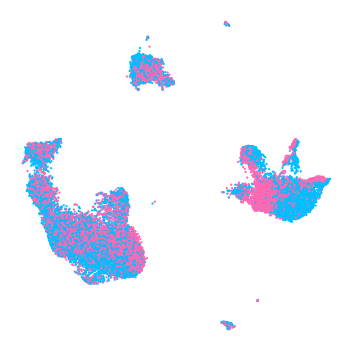

In [37]:
cm = LinearSegmentedColormap.from_list(
        'my_cm', ['deepskyblue', 'hotpink'], N=2)
fig, ax = plt.subplots(figsize=(5, 5))
order = np.arange(latent.shape[0])
random.shuffle(order)
ax.scatter(latent_u[order, 0], latent_u[order, 1], 
           c=all_dataset.batch_indices.ravel()[order], 
           cmap=cm, edgecolors='none', s=5)    
plt.axis("off")
fig.set_tight_layout(True)


In [13]:
adata_latent = sc.AnnData(latent)
sc.pp.neighbors(adata_latent, use_rep='X', n_neighbors=30, metric='minkowski')
sc.tl.louvain(adata_latent, partition_type=louvain.ModularityVertexPartition, use_weights=False)
clusters = adata_latent.obs.louvain.values.to_dense().astype(int)

/usr/local/lib/python3.6/dist-packages/scanpy/neighbors/__init__.py:89: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview:  # we shouldn't need this here...


### plot clusters in 2D UMAP


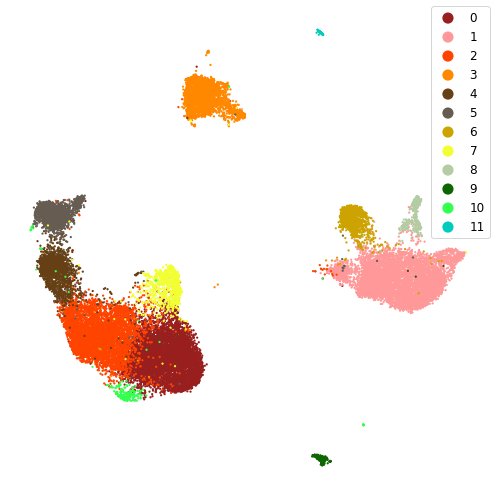

In [14]:
colors = ["#991f1f", "#ff9999", "#ff4400", "#ff8800", "#664014", "#665c52",
          "#cca300", "#f1ff33", "#b4cca3", "#0e6600", "#33ff4e", "#00ccbe",
          "#0088ff", "#7aa6cc", "#293966", "#0000ff", "#9352cc", "#cca3c9", "#cc2996"]

fig = plt.figure(figsize=(7, 7), facecolor='w', edgecolor='k')
for i, k in enumerate(np.unique(clusters)):
    plt.scatter(latent_u[clusters == k, 0], latent_u[clusters == k, 1], label=k,
                edgecolors='none', c=colors[k], s=5)
    plt.legend(borderaxespad=0, fontsize='large', markerscale=5)

plt.axis('off')
fig.set_tight_layout(True)


###### Generate list of genes that is enriched for higher expression in cluster $i$ compared to all other clusters
Here we compare the gene expression in cells from one cluster to all the other cells by 
* sampling mean parameter from the scVI ZINB model
* compare pairs of cells from one subset v.s. the other 
* compute bayes factor based on the number of times the cell from the cluster of interest has a higher expression
* generate DE genelist ranked by the bayes factor

In [15]:
# change to output_file=True to get an Excel file with all DE information
de_res, de_clust = full.one_vs_all_degenes(cell_labels=clusters, n_samples=10000, 
                                           M_permutation=10000, output_file=False,
                                           save_dir=save_path, filename='Harmonized_ClusterDE',
                                           min_cells=1)

# with open(save_path+'Harmonized_ClusterDE.pkl', 'wb') as f:
#     pickle.dump((de_res, de_clust), f)

# with open(save_path+'Harmonized_ClusterDE.pkl', 'rb') as f:
#     de_res, de_clust = pickle.load(f)


# Find markers for each cluster
**absthres** is the minimum average number of UMI in the cluster of interest to be a marker gene

**relthres** is the minimum fold change in number of UMI in the cluster of interest compared to all other cells for a differentially expressed gene to be a marker gene


In [ ]:
def find_markers(deres, absthres, relthres, ngenes):
    allgenes = []
    for i, x in enumerate(deres):
        markers = x.loc[
            (x["raw_mean1"] > absthres)
            & (x["raw_normalized_mean1"] / x["raw_normalized_mean2"] > relthres)
        ]
        if len(markers > 0):
            ngenes = np.min([len(markers), ngenes])
            markers = markers[:ngenes]
            allgenes.append(markers)
    if len(allgenes) > 0:
        markers = pd.concat(allgenes)
        return markers
    else:
        return pd.DataFrame(
            columns=["bayes_factor", "raw_mean1", "raw_mean2", "scale1", "scale2", "clusters"]
        )


In [ ]:
clustermarkers = find_markers(de_res, absthres=0.5, relthres=2, ngenes=3)

In [18]:
clustermarkers[['bayes_factor', 'raw_mean1', 'raw_mean2', 'scale1', 'scale2', 'clusters']]

,bayes_factor,raw_mean1,raw_mean2,scale1,scale2,clusters
CCR7,2.407534,3.013568,1.101134,0.013815,0.003587,0
LTB,2.268095,1.777387,0.487352,0.007570,0.001843,0
IL7R,1.927748,0.634673,0.311735,0.003167,0.001115,0
CCL2,5.595713,26.253246,0.228723,0.029112,0.000589,1
CCL7,5.355480,4.972349,0.028503,0.005568,0.000125,1
FTL,5.144079,176.007248,9.275810,0.187290,0.019729,1
TRAT1,1.910720,0.653896,0.167326,0.002602,0.000722,2
PABPC1,1.658972,6.917166,3.106116,0.023507,0.009658,2
RGS1,1.650806,0.530394,0.202526,0.002463,0.000919,2
MS4A1,5.651483,0.748272,0.006394,0.003434,0.000098,3


# Plotting known cluster unique genes

In [ ]:
Markers = ["CD3D", "SELL", "CREM", "CD8B", "GNLY", "CD79A", "FCGR3A", "CCL2", "PPBP"]

In [ ]:
def plot_marker_genes(latent_u, count, genenames, markers):
    nrow = (len(markers) // 3 + 1)
    figh = nrow * 4
    fig = plt.figure(figsize=(10, figh))
    for i, x in enumerate(markers):
        if np.sum(genenames == x)==1:
            exprs = count[:, genenames == x].ravel()
            idx = (exprs > 0)
            plt.subplot(nrow, 3, (i + 1))
            plt.scatter(latent_u[:, 0], latent_u[:, 1], c='lightgrey', edgecolors='none', s=5)
            plt.scatter(latent_u[idx, 0], latent_u[idx, 1], c=exprs[idx], cmap=plt.get_cmap('viridis_r'),
                        edgecolors='none', s=3)
            plt.title(x)
            fig.set_tight_layout(True)

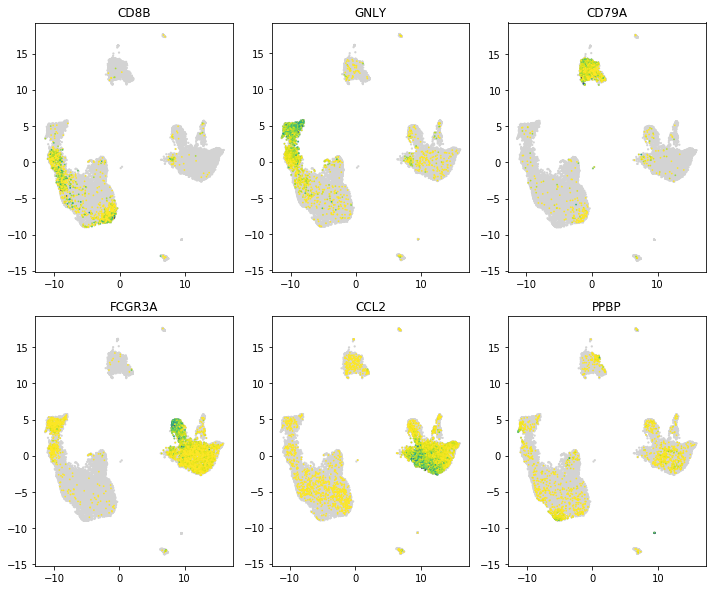

In [21]:
if len(clustermarkers) > 0:
    plot_marker_genes(latent_u[clusters >= 0, :], all_dataset.X[clusters >= 0, :], 
                  all_dataset.gene_names,
                  np.asarray(Markers))

### Here we plot the heatmap of average marker gene expression of each cluster

In [ ]:
markergenes = ["CD3D", "CREM", "HSPH1", "SELL", "GIMAP5", "CACYBP", "GNLY", 
    "NKG7", "CCL5", "CD8A", "MS4A1", "CD79A", "MIR155HG", "NME1", "FCGR3A", 
    "VMO1", "CCL2", "S100A9", "HLA-DQA1", "GPR183", "PPBP", "GNG11", "HBA2", 
    "HBB", "TSPAN13", "IL3RA", "IGJ"]

In [ ]:
percluster_exprs = []
marker_names = []
for marker in markergenes:
    if np.sum(all_dataset.gene_names == marker) == 1:
        mean = [np.mean(all_dataset.X[clusters == i, all_dataset.gene_names == marker]) for i in np.unique(clusters)]
        mean = np.asarray(mean)
        percluster_exprs.append(np.log10(mean / np.mean(mean) + 1))
        marker_names.append(marker)


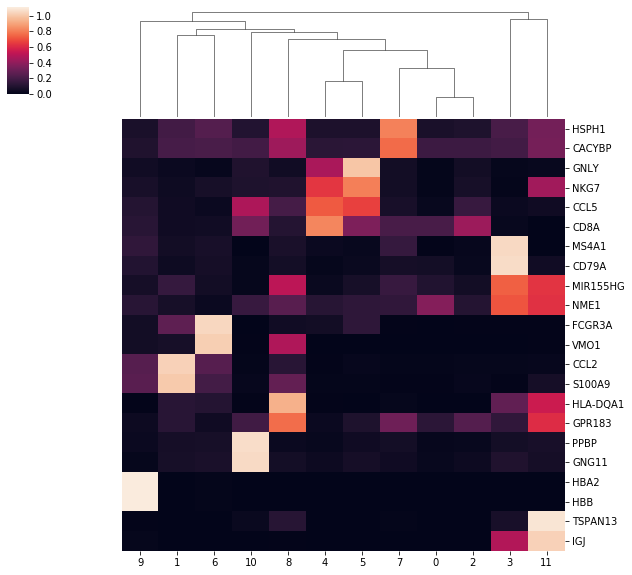

In [24]:
if len(percluster_exprs) > 0:
    percluster_exprs = pd.DataFrame(percluster_exprs, index=marker_names)
    sns.clustermap(percluster_exprs, row_cluster=False, col_cluster=True)

# Plotting scVI discovered marker genes
### Each row contains the top 3 marker gene expression of its corresponding cluster

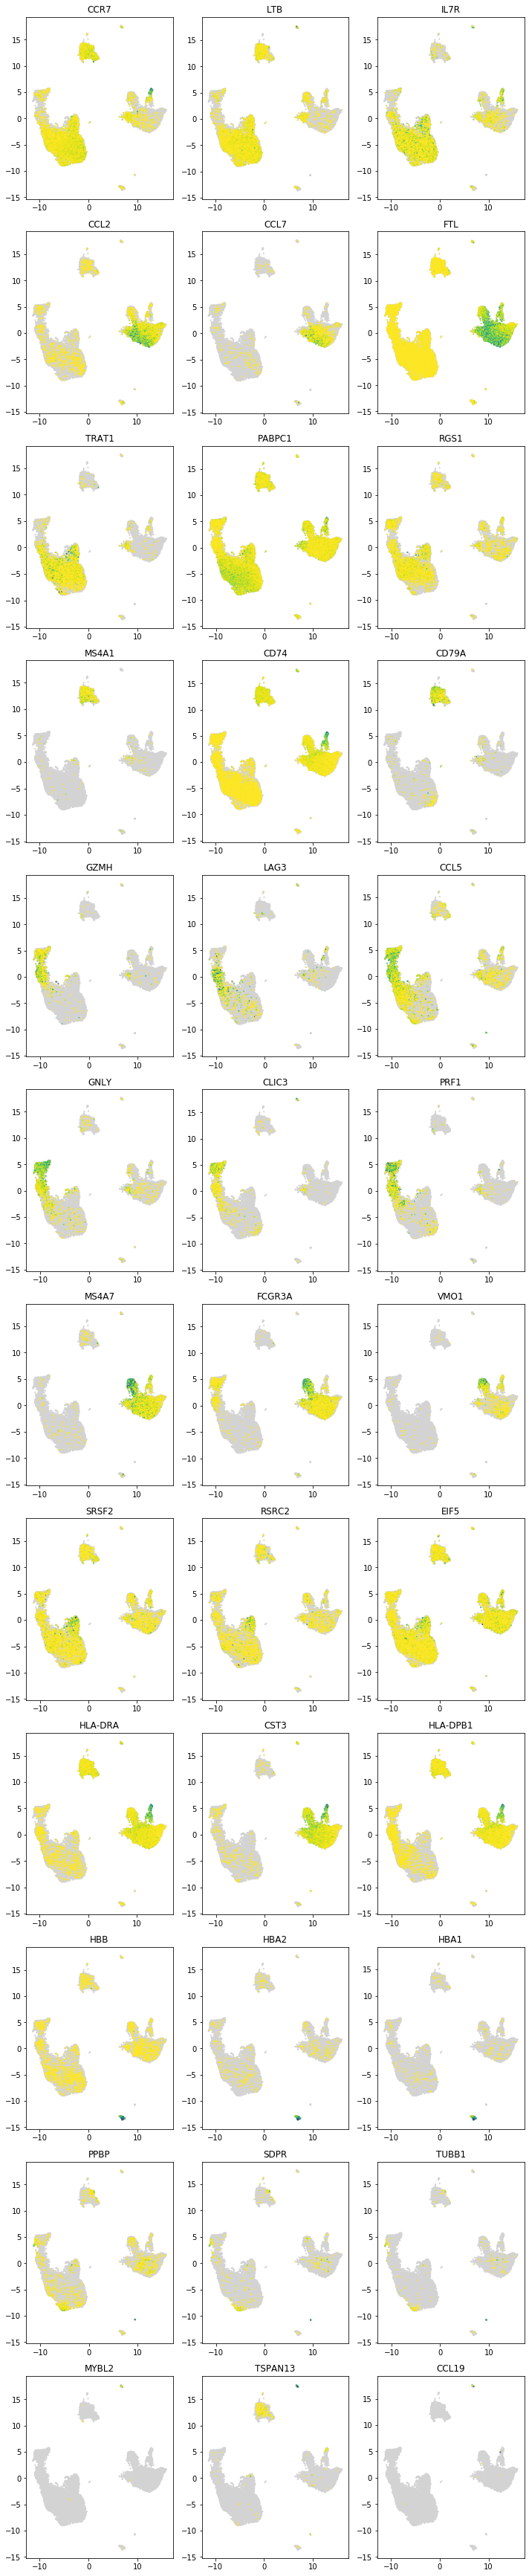

In [25]:
plot_marker_genes(latent_u[clusters >= 0, :], all_dataset.X[clusters >= 0, :],
                  all_dataset.gene_names, np.asarray(clustermarkers.index))


# Compare list of genes that are differentially expressed in each clusters

In [ ]:
# change to output_file=True to get an Excel file with all DE information
de_res_stim, de_clust_stim = full.within_cluster_degenes(cell_labels=clusters,
                                                         states=all_dataset.batch_indices.ravel() == 1,
                                                         output_file=False, batch1=[1], batch2=[0],
                                                         save_dir=save_path, filename='Harmonized_StimDE',
                                                         min_cells=1)

# with open(save_path+'Harmonized_StimDE.pkl', 'wb') as f:
#     pickle.dump((de_res_stim,de_clust_stim), f)

# with open(save_path+'Harmonized_StimDE.pkl', 'rb') as f:
#     de_res_stim,de_clust_stim = pickle.load(f)


In [ ]:
genelist = []
for i, x in enumerate(de_clust_stim):
    de = de_res_stim[i].loc[de_res_stim[i]["raw_mean1"] > 1]
    de = de.loc[de["bayes_factor"] > 2]
    if len(de) > 0:
        de["cluster"] = np.repeat(x, len(de))
        genelist.append(de)

        
if len(genelist) > 0:
    genelist = pd.concat(genelist)
    genelist["genenames"] = list(genelist.index)
    degenes, nclusterde = np.unique(genelist.index, return_counts=True)

### Genes that are differentially expressed in at least 10 of the clusters

In [28]:
if len(genelist) > 0:
    print(", ".join(degenes[nclusterde > 11]))

C15ORF48, C3AR1, CCL2, CST3, SAT1, TXN, TXNIP, TYROBP


In [ ]:
if len(genelist) > 0:
    cluster0shared = genelist.loc[genelist['genenames'].isin(degenes[nclusterde > 10])]
    cluster0shared = cluster0shared.loc[cluster0shared['cluster'] == 0]

In [ ]:
def plot_marker_genes_compare(latent_u, count, genenames, markers, subset):
    nrow = len(markers)
    figh = nrow * 4
    fig = plt.figure(figsize=(8, figh))
    notsubset = np.asarray([not x for x in subset])
    for i, x in enumerate(markers):
        if np.sum(genenames == x) == 1:
            exprs = count[:, genenames == x].ravel()
            idx = (exprs > 0)
            plt.subplot(nrow, 2, (i * 2 + 1))
            plt.scatter(latent_u[subset, 0], latent_u[subset, 1], c='lightgrey', edgecolors='none', s=5)
            plt.scatter(latent_u[idx, 0][subset[idx]], latent_u[idx, 1][subset[idx]], c=exprs[idx][subset[idx]],
                        cmap=plt.get_cmap('viridis_r'), edgecolors='none', s=3)
            plt.title(x + ' control')
            fig.set_tight_layout(True)
            plt.subplot(nrow, 2, (i * 2 + 2))
            plt.scatter(latent_u[notsubset, 0], latent_u[notsubset, 1], c='lightgrey', edgecolors='none', s=5)
            plt.scatter(latent_u[idx, 0][notsubset[idx]], latent_u[idx, 1][notsubset[idx]],
                        c=exprs[idx][notsubset[idx]], cmap=plt.get_cmap('viridis_r'), edgecolors='none', s=3)
            plt.title(x + ' stimulated')

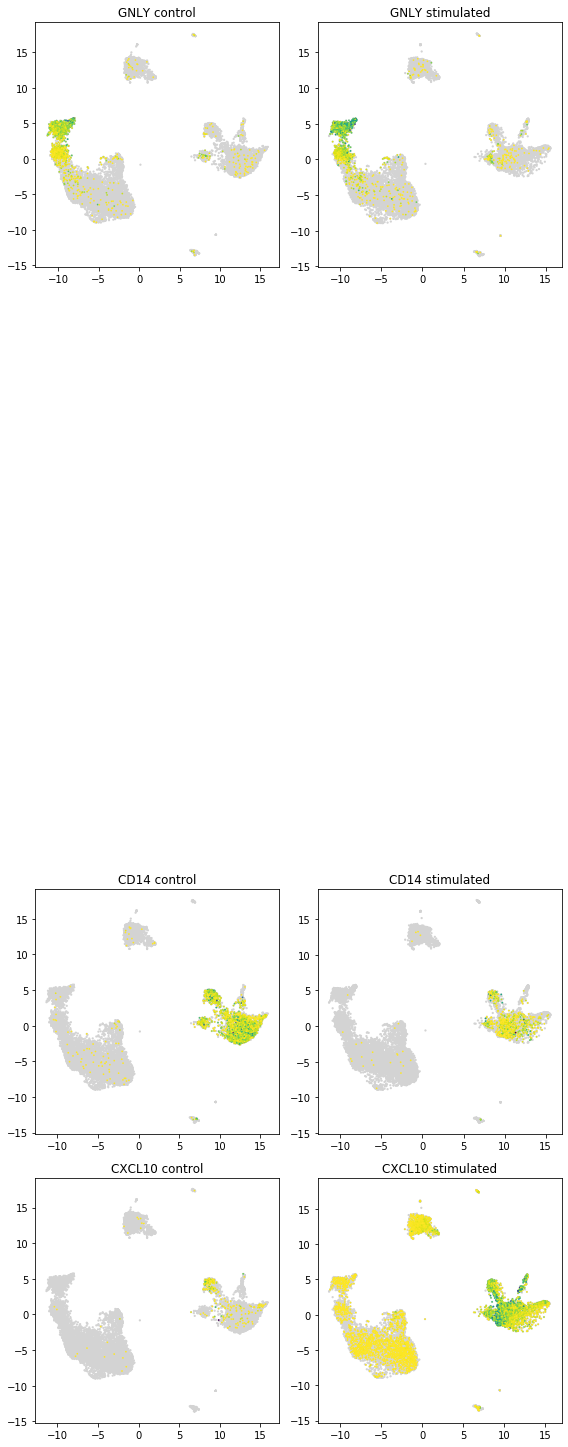

In [31]:
plot_marker_genes_compare(latent_u, all_dataset.X, all_dataset.gene_names, 
                          ["CD3D", "GNLY", "IFI6", "ISG15", "CD14", "CXCL10"], batch_indices == 0)

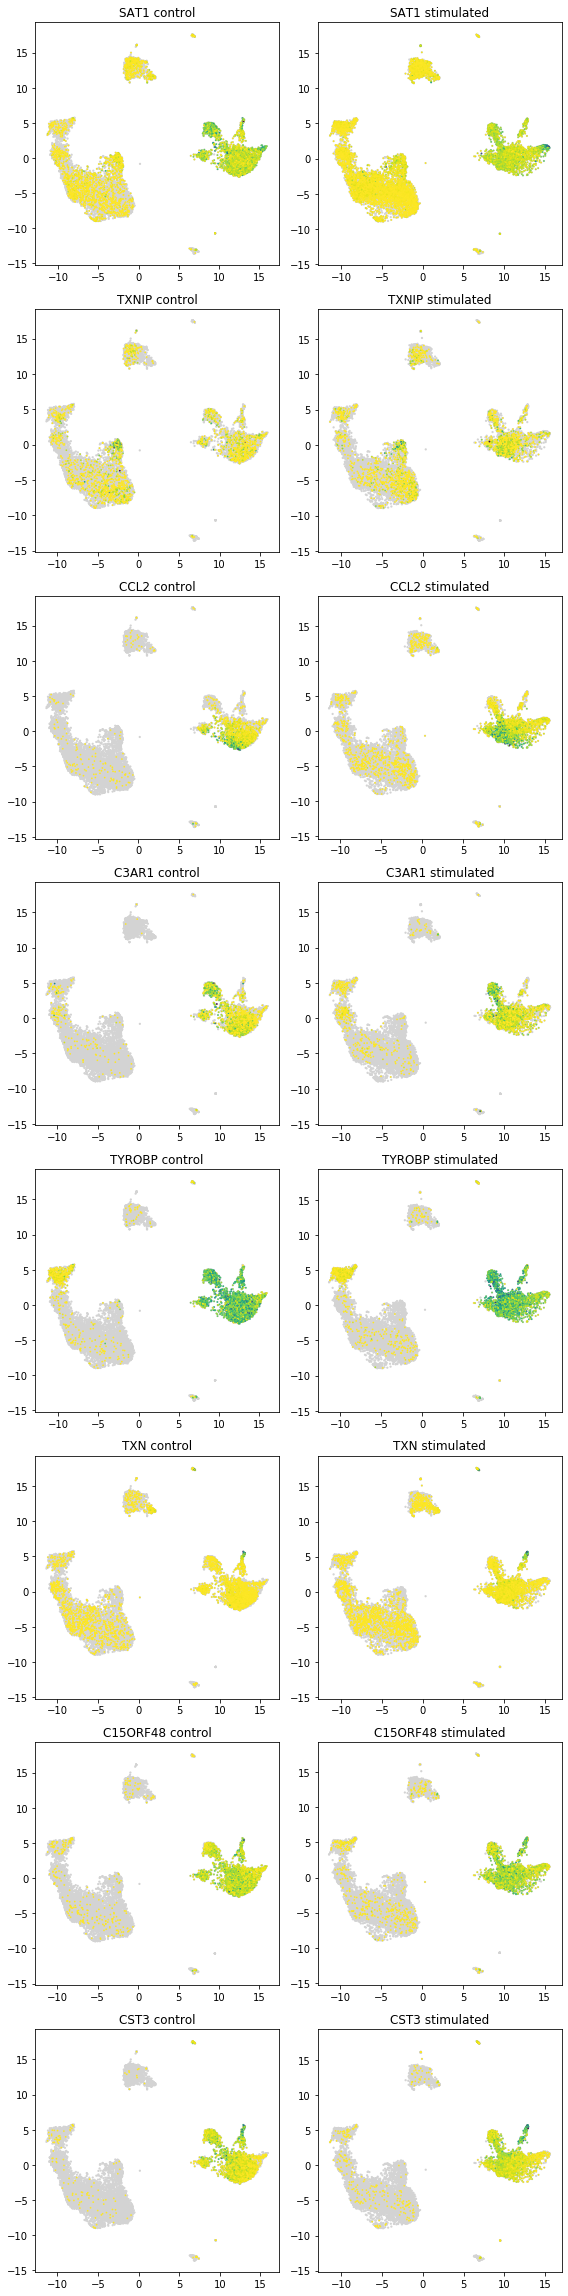

In [32]:
if len(genelist) > 0:
    plot_marker_genes_compare(latent_u, all_dataset.X, 
                          all_dataset.gene_names, cluster0shared.index, 
                          batch_indices == 0)

### Genes that are differentially expressed in one single cluster

In [35]:
if len(genelist) > 0 and len(nclusterde) > 0:
    degenes[nclusterde == 1]
    clusteruniq = genelist.loc[genelist['genenames'].isin(degenes[nclusterde == 1])]
    clusteruniq = clusteruniq.loc[clusteruniq['cluster'] == 3]
    plot_marker_genes_compare(latent_u, all_dataset.X, all_dataset.gene_names, clusteruniq.index, batch_indices == 0)

<Figure size 576x0 with 0 Axes>